1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
SEED = 0
models_results = {
    'Model': [],
    'F-score': [],
    'Precision': [],
    'Recall': [],
    'ROC-AUC': [],
    'Confusion Matrix': []
}

In [3]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
feature_cols = categorical_columns + continuous_columns
target = 'Exited'

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df[target], random_state=SEED)

Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
#Сделаем трансформер для колонок: числовых признаков с помощью StandardScaler, и категориальных с помощью OneHotEncoder
t = [('cat', OneHotEncoder(drop='first'), categorical_columns)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(
    col_transform,
    RandomForestClassifier(random_state = SEED))

Обучим модель

In [10]:
#обучим наш пайплайн
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Geography', 'Gender',
                                                   'Tenure', 'HasCrCard',
                                                   'IsActiveMember'])],
                                   verbose...
    

In [11]:
#наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.29, 0.24, 0.27, 0.01, 0.01, 0.7 , 0.02, 0.12, 0.13, 0.79])

In [12]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350000, F-Score=0.650, Precision=0.625, Recall=0.676


Отрисуем матрицу ошибок

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1795  196]
 [ 172  337]]


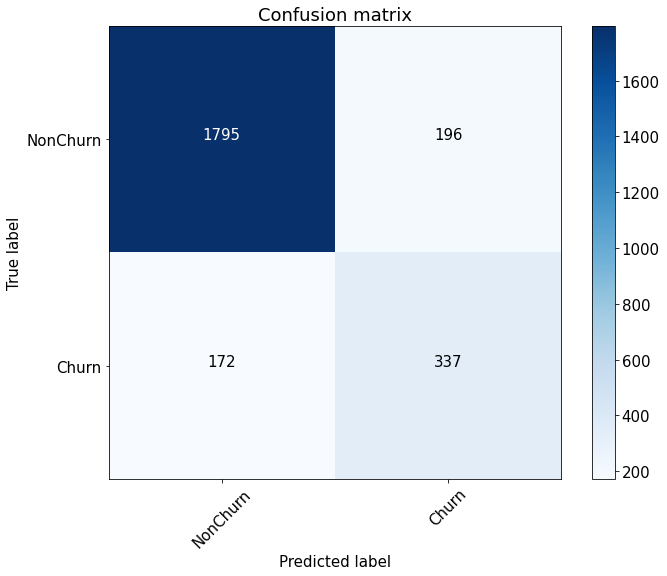

In [15]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [20]:
models_results['Model'].append('RandomForest')
models_results['F-score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['ROC-AUC'].append(roc_auc_score(y_test, preds))
models_results['Confusion Matrix'].append(cnf_matrix)

Попробуем Catboost

In [23]:
import catboost

In [24]:
X_train, X_val, y_train, y_val = train_test_split(df[feature_cols], df[target], 
                                                  random_state=SEED)

In [25]:
clf = catboost.CatBoostClassifier(random_seed=SEED)

In [26]:
clf.fit(
    X_train, y_train,
    cat_features=categorical_columns,
)

Learning rate set to 0.024355
0:	learn: 0.6732734	total: 56.9ms	remaining: 56.8s
1:	learn: 0.6546409	total: 65ms	remaining: 32.4s
2:	learn: 0.6372412	total: 72.3ms	remaining: 24s
3:	learn: 0.6214332	total: 79ms	remaining: 19.7s
4:	learn: 0.6057064	total: 86.6ms	remaining: 17.2s
5:	learn: 0.5910305	total: 94.3ms	remaining: 15.6s
6:	learn: 0.5766300	total: 105ms	remaining: 15s
7:	learn: 0.5630720	total: 113ms	remaining: 14s
8:	learn: 0.5507865	total: 120ms	remaining: 13.2s
9:	learn: 0.5419090	total: 127ms	remaining: 12.5s
10:	learn: 0.5305959	total: 134ms	remaining: 12s
11:	learn: 0.5208150	total: 141ms	remaining: 11.6s
12:	learn: 0.5114535	total: 148ms	remaining: 11.3s
13:	learn: 0.5016030	total: 156ms	remaining: 11s
14:	learn: 0.4943738	total: 163ms	remaining: 10.7s
15:	learn: 0.4866827	total: 171ms	remaining: 10.5s
16:	learn: 0.4811981	total: 176ms	remaining: 10.2s
17:	learn: 0.4756414	total: 185ms	remaining: 10.1s
18:	learn: 0.4686879	total: 194ms	remaining: 10s
19:	learn: 0.4614436	

In [27]:
#наши прогнозы для тестовой выборки
preds = clf.predict_proba(X_val)[:, 1]

In [28]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.417370, F-Score=0.648, Precision=0.698, Recall=0.605


Confusion matrix, without normalization
[[1858  133]
 [ 202  307]]


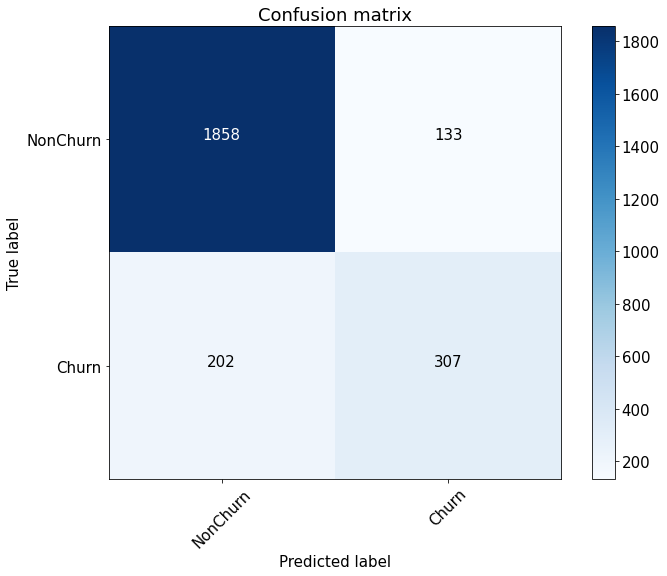

In [29]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [30]:
models_results['Model'].append('Catboost')
models_results['F-score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['ROC-AUC'].append(roc_auc_score(y_val, preds))
models_results['Confusion Matrix'].append(cnf_matrix)

Сделаем модель логистической регрессии

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df[target], random_state=SEED)

In [32]:
#Сделаем трансформер для колонок: числовых признаков с помощью StandardScaler, и категориальных с помощью OneHotEncoder
t = [('cat', OneHotEncoder(drop='first'), categorical_columns), ('num', StandardScaler(), continuous_columns)]
col_transform = ColumnTransformer(transformers=t)

In [33]:
model = make_pipeline(
    col_transform,
    LogisticRegression(random_state = SEED))

In [34]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Geography', 'Gender',
                                                   'Tenure', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('num',
 

In [35]:
preds = model.predict_proba(X_test)[:, 1]

In [36]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.284569, F-Score=0.509, Precision=0.455, Recall=0.578


Confusion matrix, without normalization
[[1639  352]
 [ 216  293]]


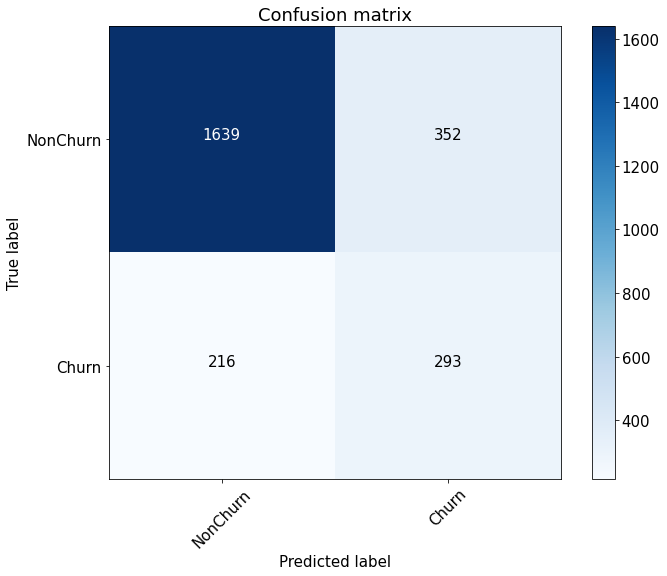

In [37]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [38]:
models_results['Model'].append('LogRegression')
models_results['F-score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['ROC-AUC'].append(roc_auc_score(y_val, preds))
models_results['Confusion Matrix'].append(cnf_matrix)

In [39]:
pd.DataFrame(data=models_results).sort_values('Precision', ascending=False)

,Model,F-score,Precision,Recall,ROC-AUC,Confusion Matrix
1,Catboost,0.648421,0.698413,0.605108,0.879072,"[[1858, 133], [202, 307]]"
0,RandomForest,0.649669,0.625455,0.675835,0.865678,"[[1795, 196], [172, 337]]"
2,LogRegression,0.509091,0.455108,0.577603,0.772102,"[[1639, 352], [216, 293]]"


Мне кажется нам тут важнее будет `Precision`, так как мы тратим на каждое предложение клиенту деньги, и каждый `FP` это потеря денег, нам важно получить как можно больше `TP` .

Confusion matrix, without normalization
[[1858  133]
 [ 202  307]]


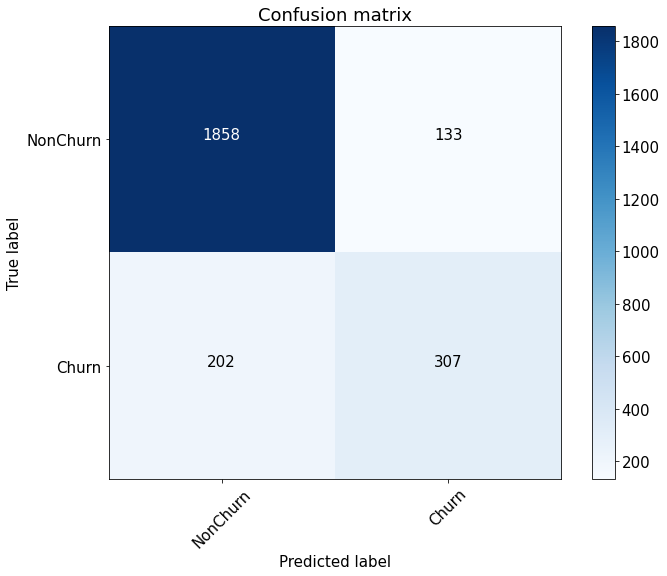

In [40]:
font = {'size' : 15}

plt.rc('font', **font)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(models_results['Confusion Matrix'][-2], classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного)

In [41]:
FP = 133
TP = 307
income = TP * 2
expense = (TP+FP)
print(f'Экономическая эффективность: {income - expense}$')

Экономическая эффективность: 174$


Попробуем оптимизировать лучшую модель, т.е Catboost

In [284]:
X_train, X_val, y_train, y_val = train_test_split(df[feature_cols], df[target], 
                                                  random_state=SEED)

In [285]:
frozen_params = {
     'auto_class_weights' : 'Balanced',
     #'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':SEED,
     'cat_features':categorical_columns,
     'eval_metric':'F1',
     'early_stopping_rounds':200,
}

In [286]:
clf_balanced = catboost.CatBoostClassifier(**frozen_params)

In [287]:
cv = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

In [288]:
params = {'n_estimators':[500, 1000], 
          'max_depth':[3,5,7,9],
          'l2_leaf_reg': [5,9]
          }

In [289]:
grid_search = clf_balanced.grid_search(params, X_train, y_train, cv=cv, stratified=True, refit=True)


bestTest = 0.7732094915
bestIteration = 442

0:	loss: 0.7732095	best: 0.7732095 (0)	total: 2.76s	remaining: 41.3s

bestTest = 0.7722088206
bestIteration = 473

1:	loss: 0.7722088	best: 0.7732095 (0)	total: 5.56s	remaining: 38.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7732094915
bestIteration = 442

2:	loss: 0.7732095	best: 0.7732095 (0)	total: 9.07s	remaining: 39.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.773543625
bestIteration = 525

3:	loss: 0.7735436	best: 0.7735436 (3)	total: 13.1s	remaining: 39.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7748226561
bestIteration = 212

4:	loss: 0.7748227	best: 0.7748227 (4)	total: 16.2s	remaining: 35.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7686330605
bestIteration = 171

5:	loss: 0.7686331	best: 0.7748227 (4)	total: 18.9s	remaining: 31.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7748226561
bestIterati

In [290]:
preds = clf_balanced.predict_proba(X_val)[:, 1]

In [291]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = ((1 + 0.8**2) * precision * recall) / (0.8**2 * precision + recall)
#fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.681503, F-Score=0.655, Precision=0.666, Recall=0.639


Confusion matrix, without normalization
[[1828  163]
 [ 185  324]]


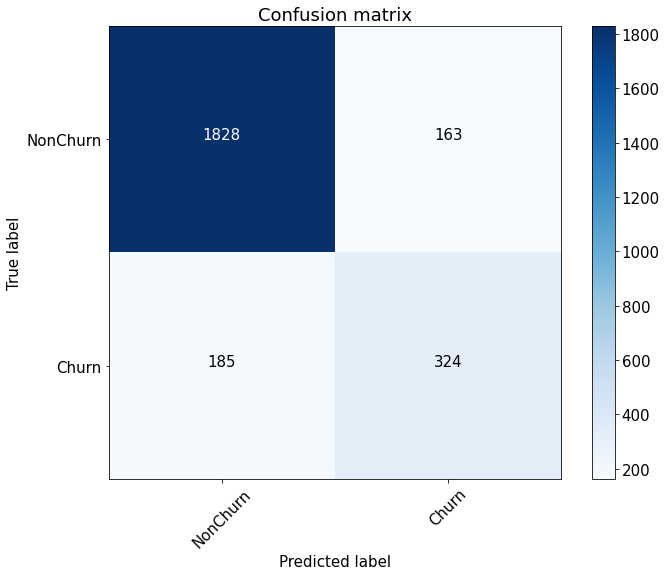

In [292]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [293]:
FP = 163
TP = 324
income = TP * 2
expense = (TP+FP)
print(f'Экономическая эффективность: {income - expense}$')

Экономическая эффективность: 161$


In [47]:
import pickle
import optuna

In [86]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(df[feature_cols], df[target], 
                                                  test_size=0.2, random_state=SEED, stratify=df[target])
    
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]

    param = {
        "objective": "Logloss",
        "depth": trial.suggest_int("depth", 1, 12),
        "used_ram_limit": "3gb",
        'cat_features':categorical_columns,
        'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 1, 20),
        'eval_metric':'F1',
        'n_estimators':trial.suggest_int("n_estimators", 1000, 10000, 500),
        'class_weights':[1, disbalance]

    }


    gbm = catboost.CatBoostClassifier(**param)
    # cv = StratifiedKFold(n_splits=7, random_state=SEED, shuffle=True)
    gbm.fit(train_x, train_y, eval_set=(valid_x, valid_y), verbose=0, early_stopping_rounds=400)

    preds = gbm.predict_proba(valid_x)[:, 1]
    # pred_labels = np.rint(preds)
    precision, recall, thresholds = precision_recall_curve(valid_y, preds)
    fscore = ((1 + 1**2) * precision * recall) / (1**2 * precision + recall)
    ix = np.argmax(fscore)
    #accuracy = roc_auc_score(valid_y, preds)
        # Save a trained model to a file.
    with open("{}.pickle".format(trial.number), "wb") as fout:
         pickle.dump(gbm, fout)
    return fscore[ix]

In [87]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2021-03-21 23:22:13,474] A new study created in memory with name: no-name-1b0a81d4-813e-422e-86a2-2333f26b6c10
[I 2021-03-21 23:22:20,387] Trial 0 finished with value: 0.6266318537859008 and parameters: {'depth': 8, 'l2_leaf_reg': 3, 'n_estimators': 6000}. Best is trial 0 with value: 0.6266318537859008.
[I 2021-03-21 23:22:42,858] Trial 1 finished with value: 0.6186335403726708 and parameters: {'depth': 12, 'l2_leaf_reg': 8, 'n_estimators': 7000}. Best is trial 0 with value: 0.6266318537859008.
[I 2021-03-21 23:22:50,447] Trial 2 finished with value: 0.6251588310038119 and parameters: {'depth': 7, 'l2_leaf_reg': 17, 'n_estimators': 4500}. Best is trial 0 with value: 0.6266318537859008.
[I 2021-03-21 23:22:59,170] Trial 3 finished with value: 0.6261558784676354 and parameters: {'depth': 9, 'l2_leaf_reg': 9, 'n_estimators': 1500}. Best is trial 0 with value: 0.6266318537859008.
[I 2021-03-21 23:23:07,857] Trial 4 finished with value: 0.6212319790301442 and parameters: {'depth': 8, 'l2

In [88]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.6334106728538283
  Params: 
    depth: 5
    l2_leaf_reg: 3
    n_estimators: 8500


In [90]:
with open("{}.pickle".format(study.best_trial.number), "rb") as fin:
    best_clf = pickle.load(fin)

In [91]:
preds =  best_clf.predict_proba(X_val)[:, 1]

In [92]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = ((1 + 0.8**2) * precision * recall) / (0.8**2 * precision + recall)
#fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.699785, F-Score=0.656, Precision=0.701, Recall=0.595


Confusion matrix, without normalization
[[1862  129]
 [ 207  302]]


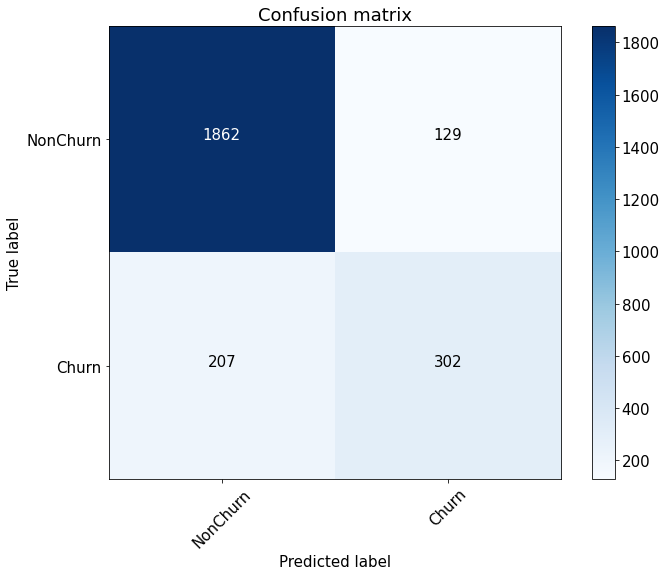

In [93]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [94]:
FP = 129
TP = 302
income = TP * 2
expense = (TP+FP)
print(f'Экономическая эффективность: {income - expense}$')

Экономическая эффективность: 173$
